<a href="https://colab.research.google.com/github/MoriyaBitton/Data_Science_Final_Project/blob/main/Home_Depot_Data_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [4]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.utils import to_categorical
import seaborn as sns
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor

In [5]:
path = '/content/drive/My Drive/Home Depot Data/'

**About The Data:**

This data set contains a number of products and real customer search terms from Home Depot's website.In this Assignment we need to predict a relevance score for the provided combinations of search terms and products (first, character level and than word/character-combination level). To create the ground truth labels, Home Depot has crowdsourced the search/product pairs to multiple human raters.

The relevance (label) is a number between 1 (not relevant) to 3 (highly relevant).

**Main data:**

train.csv - the training set, contains products, searches, and relevance scores.columns: id, product_uid, product_title, search_term, relevance

test.csv - the test set, contains products and searches. You must predict the relevance for these pairs.columns: id, product_uid, product_title, search_term.

product_descriptions.csv - contains a text description of each product. columns: product_uid, product_description


In [6]:
def read_data():
  train = pd.read_csv(path + 'train.csv', encoding = "ISO-8859-1")
  test = pd.read_csv(path + 'test.csv', encoding = "ISO-8859-1")
  prod_des = pd.read_csv(path +'product_descriptions.csv', encoding = "ISO-8859-1")
  train = train.merge(prod_des, how='left', on='product_uid')
  test = test.merge(prod_des, how='left', on='product_uid')
  return train,test,prod_des

After a deep look in the test file, we saw that there is no lable column in the test (no relevant score), we fill this column with a solution file, that contains the relevance field for the test.

In [7]:
def add_label(test, prod_des):
  solution = pd.read_csv(path + 'solution.csv', encoding = "ISO-8859-1")
  solution = solution.merge(test, how='left', on = 'id')
  solution.drop(solution[solution.relevance < 0].index, inplace=True)
  return solution

In [8]:
train, test, prod_des = read_data()
test = add_label(test, prod_des)

ASCII characters are ultimately interpreted by the computer as hexadecimal. In consequence, to a computer, ‘A’ is not the same as ‘a’. 

Therefore, we’ll want to change all characters to lowercase. Since we’re going to be splitting the sentences up into individual words based off of white spaces, a word with a period right after it is not equivalent to one without a period following it (happy. != happy). In addition, contractions are going to be interpreted differently than the original which will have repercussions for the model (I’m != I am). Thus, we replace all occurrences using the proceeding function


In [9]:
replace_list = {r"i'm": 'i am',
                r"'re": ' are',
                r"let’s": 'let us',
                r"'s":  ' is',
                r"'ve": ' have',
                r"can't": 'can not',
                r"cannot": 'can not',
                r"shan’t": 'shall not',
                r"n't": ' not',
                r"'d": ' would',
                r"'ll": ' will',
                r"'scuse": 'excuse',
                ',': ' ,',
                '.': ' .',
                '!': ' !',
                '?': ' ?',
                '\s+': ' '}
def clean_text(text):
    text = text.lower() ###
    for s in replace_list:
        text = text.replace(s, replace_list[s])
    text = ' '.join(text.split())
    return text

In [10]:
train['search_term'] = train['search_term'].apply(lambda p: clean_text(p))
train['product_description'] = train['product_description'].apply(lambda p: clean_text(p))
test['search_term'] = test['search_term'].apply(lambda p: clean_text(p))
test['product_description'] = test['product_description'].apply(lambda p: clean_text(p))

We delete all stop words to reduce the number of words

In [11]:
stoplist = set('for a of the and to in'.split(' '))

In [12]:
train['search_term'] = train['search_term'].apply(lambda p: [word for word in p.split(' ') if word not in stoplist])
train['product_description'] = train['product_description'].apply(lambda p: [word for word in p.split(' ') if word not in stoplist])
test['search_term'] = test['search_term'].apply(lambda p: [word for word in p.split(' ') if word not in stoplist])
test['product_description'] = test['product_description'].apply(lambda p: [word for word in p.split(' ') if word not in stoplist])

In [13]:
s = ''
train['search_term'] = train['search_term'].apply(lambda p: s.join(p))
train['product_description'] = train['product_description'].apply(lambda p: s.join(p))
test['search_term'] = test['search_term'].apply(lambda p: s.join(p))
test['product_description'] = test['product_description'].apply(lambda p: s.join(p))

In [14]:
train['search_term'] = train['search_term'].apply(lambda p: " ".join(p))
train['product_description'] = train['product_description'].apply(lambda p: " ".join(p))
test['search_term'] = test['search_term'].apply(lambda p: " ".join(p))
test['product_description'] = test['product_description'].apply(lambda p: " ".join(p))

In [15]:
def count_words(strs):
  str_search, str_words = strs
  return sum(int(str_search.find(word) >= 0) for word in str_words.split())

In [16]:
train['ctr_chars_desc'] = train[['search_term','product_description']].apply(count_words, axis = 1)
test['ctr_chars_desc'] = test[['search_term','product_description']].apply(count_words, axis = 1)

# more to train
train['ctr_chars_title'] = train[['search_term','product_title']].apply(count_words, axis = 1)
test['ctr_chars_title'] = test[['search_term','product_title']].apply(count_words, axis = 1)

In [17]:
x_train = train.copy()
y_train = x_train['relevance']
x_train = x_train.drop(columns=['id','product_title','search_term','product_description','relevance'])

x_test = test.copy()
x_test = x_test.drop(columns=['Usage','id','product_title','search_term','product_description','relevance'])
y_test = test['relevance']

# Linear Regression

In [18]:
lr = LinearRegression()
lr.fit(x_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [19]:
test_preds = lr.predict(x_test)

In [20]:
RMSE = format(mean_squared_error(y_test, test_preds))
MAE = format(mean_absolute_error(y_test, test_preds))
MSE = format(np.sqrt(mean_squared_error(y_test, test_preds)))

print('Test RMSE loss: ', RMSE)
print('Test MAE loss: ', MAE)
print('Test MSE loss: ', MSE)

Test RMSE loss:  0.28069022144316425
Test MAE loss:  0.43492100358624547
Test MSE loss:  0.5298020587381331


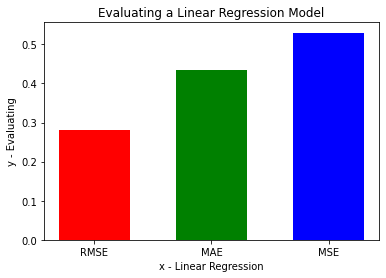

In [32]:
# x-coordinates of left sides of bars  
left = [1, 2, 3] 
  
# heights of bars 
height = [0.28069, 0.43492, 0.5298] 
  
# labels for bars 
tick_label = ['RMSE', 'MAE', 'MSE'] 
  
# plotting a bar chart 
plt.bar(left, height, tick_label = tick_label, 
        width = 0.6, color = ['red', 'green', 'blue']) 
  
# naming the x-axis 
plt.xlabel('x - Linear Regression') 
# naming the y-axis 
plt.ylabel('y - Evaluating') 
# plot title 
plt.title('Evaluating a Linear Regression Model') 
  
# function to show the plot 
plt.show()

# Gradient Boosting Regressor

In [33]:
reg = GradientBoostingRegressor(random_state=0, alpha = 0.9)

In [34]:
reg.fit(x_train, y_train)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=0, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [35]:
test_preds = reg.predict(x_test)

In [36]:
RMSE_ = format(mean_squared_error(y_test, test_preds))
MAE_ = format(mean_absolute_error(y_test, test_preds))
MSE_ = format(np.sqrt(mean_squared_error(y_test, test_preds)))

print('Test RMSE loss: ', RMSE_)
print('Test MAE loss: ', MAE_)
print('Test MSE loss: ', MSE_)

Test RMSE loss:  0.275797811468459
Test MAE loss:  0.4343524278789263
Test MSE loss:  0.5251645565615211


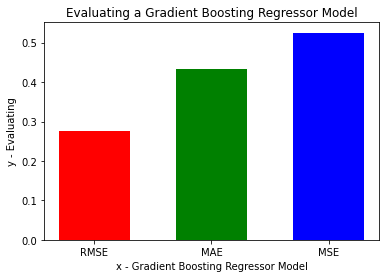

In [42]:
# x-coordinates of left sides of bars  
left = [1, 2, 3] 
  
# heights of bars 
height = [0.27579, 0.43435, 0.52516] 
  
# labels for bars 
tick_label = ['RMSE', 'MAE', 'MSE'] 
  
# plotting a bar chart 
plt.bar(left, height, tick_label = tick_label, 
        width = 0.6, color = ['red', 'green', 'blue']) 
  
# naming the x-axis 
plt.xlabel('x - Gradient Boosting Regressor Model') 
# naming the y-axis 
plt.ylabel('y - Evaluating') 
# plot title 
plt.title('Evaluating a Gradient Boosting Regressor Model') 
  
# function to show the plot 
plt.show()

Compare between the two linears Models

In [47]:
graph = pd.DataFrame(np.array([["Linear Regression", RMSE, MAE, MSE], ["Gradient Boosting Regressor", RMSE_, MAE_, MSE_]]),
                   columns = ["model name", "RMSE", "MAE", "MSE"])
graph

,model name,RMSE,MAE,MSE
0,Linear Regression,0.28069022144316425,0.43492100358624547,0.5298020587381331
1,Gradient Boosting Regressor,0.275797811468459,0.4343524278789263,0.5251645565615211


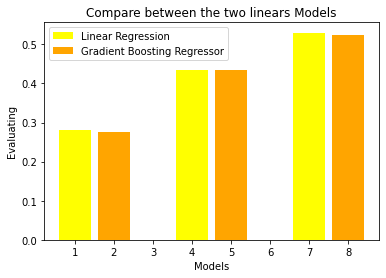

In [48]:
# Look at index 4 and 6, which demonstrate overlapping cases.
x1 = [1, 4, 7]
y1 = [0.28069022, 0.434921003, 0.52980205]

x2 = [2, 5, 8]
y2 = [0.275797811, 0.434353524, 0.525164556]

# Colors: https://matplotlib.org/api/colors_api.html

plt.bar(x1, y1, label="Linear Regression", color='yellow')
plt.bar(x2, y2, label="Gradient Boosting Regressor", color='orange')
plt.plot()

plt.xlabel("Models")
plt.ylabel("Evaluating")
plt.title("Compare between the two linears Models")
plt.legend()
plt.show()